In [1]:
import pandas as pd
import numpy as np
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import math
import slates

def setup_outcomes():
    return {('Mac', 'wifi', 'CA'): [], ('Mac', 'wifi', 'US'): [], ('Mac', 'wired', 'CA'): [], ('Mac', 'wired', 'US'): [], ('Windows', 'wifi', 'CA'): [], ('Windows', 'wifi', 'US'): [], ('Windows', 'wired', 'CA'): [], ('Windows', 'wired', 'US'): []}

In [2]:
GROUND_TRUTH_DATASET = "data/less_random_only_reverse/df_all_8_6_4_10runs.csv"
TEST_DATASETS = {
#     "20_15_10" : "data/gen/df_all_20_15_10_5runs.csv",
    "8_6_4" : "data/less_random_only_reverse/df_all_8_6_4_5runs.csv"
#     "4_3_2" : "data/df_all_4_3_2_5runs_v1.csv"
}

In [3]:
test_configs = {}
for name in TEST_DATASETS:
    test_configs[name] = {}
    df = pd.read_csv(TEST_DATASETS[name])
    test_configs[name]["data"] = df
    test_configs[name]["rewards"] = pd.DataFrame(df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()
    test_configs[name]["x"] = sorted(df["x"].unique())
    test_configs[name]["y"] = sorted(df["y"].unique())
    test_configs[name]["z"] = sorted(df["z"].unique())
    test_configs[name]["x_actions"] = ["x="+str(a) for a in test_configs[name]["x"]]
    test_configs[name]["y_actions"] = ["y="+str(a) for a in test_configs[name]["y"]]
    test_configs[name]["z_actions"] = ["z="+str(a) for a in test_configs[name]["z"]]
    
#     all_string_actions, all_actions = slates.combine_float_actions(test_configs[name]["x"],test_configs[name]["y"],test_configs[name]["z"])
    all_string_actions, all_actions = slates.combine_float_actions_categorical(test_configs[name]["x"],test_configs[name]["y"],test_configs[name]["z"])
    test_configs[name]["all_string_actions"] = all_string_actions
    test_configs[name]["all_actions"] = all_actions


In [4]:
all_string_actions

['x=0.0,y=0.0,z=0.0',
 'x=0.0,y=0.0,z=0.6667',
 'x=0.0,y=0.0,z=1.3333',
 'x=0.0,y=0.0,z=2.0',
 'x=0.0,y=0.6,z=0.0',
 'x=0.0,y=0.6,z=0.6667',
 'x=0.0,y=0.6,z=1.3333',
 'x=0.0,y=0.6,z=2.0',
 'x=0.0,y=1.2,z=0.0',
 'x=0.0,y=1.2,z=0.6667',
 'x=0.0,y=1.2,z=1.3333',
 'x=0.0,y=1.2,z=2.0',
 'x=0.0,y=1.8,z=0.0',
 'x=0.0,y=1.8,z=0.6667',
 'x=0.0,y=1.8,z=1.3333',
 'x=0.0,y=1.8,z=2.0',
 'x=0.0,y=2.4,z=0.0',
 'x=0.0,y=2.4,z=0.6667',
 'x=0.0,y=2.4,z=1.3333',
 'x=0.0,y=2.4,z=2.0',
 'x=0.0,y=3.0,z=0.0',
 'x=0.0,y=3.0,z=0.6667',
 'x=0.0,y=3.0,z=1.3333',
 'x=0.0,y=3.0,z=2.0',
 'x=0.5714,y=0.0,z=0.0',
 'x=0.5714,y=0.0,z=0.6667',
 'x=0.5714,y=0.0,z=1.3333',
 'x=0.5714,y=0.0,z=2.0',
 'x=0.5714,y=0.6,z=0.0',
 'x=0.5714,y=0.6,z=0.6667',
 'x=0.5714,y=0.6,z=1.3333',
 'x=0.5714,y=0.6,z=2.0',
 'x=0.5714,y=1.2,z=0.0',
 'x=0.5714,y=1.2,z=0.6667',
 'x=0.5714,y=1.2,z=1.3333',
 'x=0.5714,y=1.2,z=2.0',
 'x=0.5714,y=1.8,z=0.0',
 'x=0.5714,y=1.8,z=0.6667',
 'x=0.5714,y=1.8,z=1.3333',
 'x=0.5714,y=1.8,z=2.0',
 'x=0.5714,y

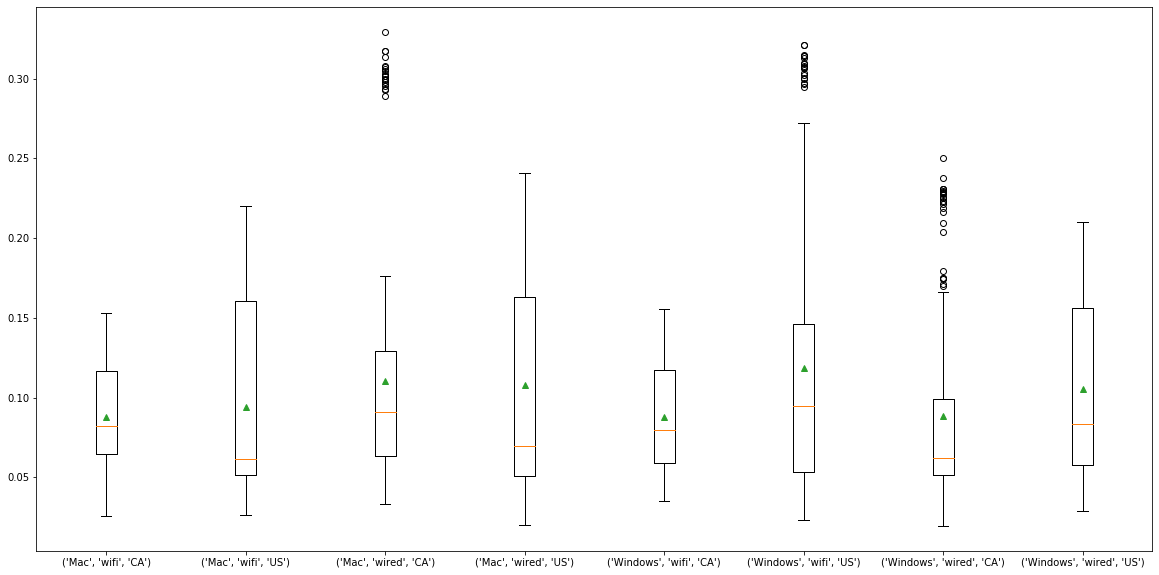

In [5]:
ground_truth_df = pd.read_csv(GROUND_TRUTH_DATASET)
ground_truth_rewards_df = pd.DataFrame(ground_truth_df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()

min_reward = {}
min_actions = {}

plt.figure(figsize=(20, 10))

grps_context = ground_truth_df.groupby(['platform', 'network', 'country'])
for i, context in enumerate(grps_context.groups.keys()):
    df_temp = grps_context.get_group(context)
    if context not in min_reward.keys():
        min_reward[context] = {}
    grps_action = df_temp.groupby(['x', 'y', 'z'])
    for action in grps_action.groups.keys():
        df_temp2 = grps_action.get_group(action)
        min_reward[context][action] = np.median(df_temp2['reward'])
        
    min_reward_action = min(min_reward[context], key=min_reward[context].get)
    min_actions[context] = min_reward_action
    plt.boxplot(grps_action.get_group(min_reward_action)["reward"], positions=[i], labels=["{}".format(context)], showmeans=True)

plt.show()


In [6]:
def optimal_policy_sample(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.random.choice(possible_rewards)

def optimal_policy_median(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.median(possible_rewards)

# Slates

In [7]:
for name in test_configs:
    test_configs[name]["outcomes"] = setup_outcomes()
    test_configs[name]["x_outcomes"] = setup_outcomes()
    test_configs[name]["y_outcomes"] = setup_outcomes()
    test_configs[name]["z_outcomes"] = setup_outcomes()
    
    model = pyvw.vw("--ccb_explore_adf --power_t 0 -l 0.005 --slate --quiet --epsilon 0.2 --interactions UA AUS SA US")

    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]
    
    for _ in range(10000):
        choice = np.random.choice(len(df))
        current_row = df.iloc[choice]
        platform = current_row["platform"]
        country = current_row["country"]
        network = current_row["network"]

        shared_context = "platform={},region={},connection={}".format(platform, country, network)
        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]])
        pred = slates.slate_pred_conv(model.predict(examples, prediction_type=pyvw.pylibvw.vw.pDECISION_SCORES))
        model.finish_example(examples)
        pred,_,_ = slates.sample(pred)

        chosen_x = test_configs[name]["x"][pred[0][0][0]]
        chosen_y = test_configs[name]["y"][pred[1][0][0]]
        chosen_z = test_configs[name]["z"][pred[2][0][0]]
        
        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_x)
                                       & (rewards['y'] == chosen_y)
                                       & (rewards['z'] == chosen_z)
                                      ]
        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)
        test_configs[name]["outcomes"][(platform,network,country)].append(cost)

        x_index = test_configs[name]["x_actions"].index("x="+str(chosen_x))
        y_index = test_configs[name]["y_actions"].index("y="+str(chosen_y))
        z_index = test_configs[name]["z_actions"].index("z="+str(chosen_z))
        x_outcome = (x_index, cost, 1/len(test_configs[name]["x"]))
        y_outcome = (y_index, cost, 1/len(test_configs[name]["y"]))
        z_outcome = (z_index, cost, 1/len(test_configs[name]["z"]))

        test_configs[name]["x_outcomes"][(platform,network,country)].append(test_configs[name]["x"][x_index])
        test_configs[name]["y_outcomes"][(platform,network,country)].append(test_configs[name]["y"][y_index])
        test_configs[name]["z_outcomes"][(platform,network,country)].append(test_configs[name]["z"][z_index])    

        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]], [x_outcome,y_outcome,z_outcome])
        model.learn(examples)
        model.finish_example(examples)


# Combinatorial CB

In [8]:
for name in test_configs:
    test_configs[name]["cb_outcomes"] = setup_outcomes()
    test_configs[name]["cb_x_outcomes"] = setup_outcomes()
    test_configs[name]["cb_y_outcomes"] = setup_outcomes()
    test_configs[name]["cb_z_outcomes"] = setup_outcomes()
    
    cb_model = pyvw.vw("--cb_explore_adf --power_t 0 -l 0.005 --quiet --epsilon 0.2 -q UA")

    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]
    for _ in range(10000):
        choice = np.random.choice(len(df))
        current_row = df.iloc[choice]
        platform = current_row["platform"]
        country = current_row["country"]
        network = current_row["network"]

        shared_context = "platform={},region={},connection={}".format(platform, country, network)
        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"])
        pred = cb_model.predict(examples, prediction_type=pyvw.pylibvw.vw.pACTION_SCORES)
        cb_model.finish_example(examples)

        # Normalize and sample
        pred_sum = sum(pred)
        pred = [float(i)/pred_sum for i in pred]
        chosen_action_index = np.random.choice(len(pred), p=pred)
        chosen_action = test_configs[name]["all_actions"][chosen_action_index]

        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_action[0])
                                       & (rewards['y'] == chosen_action[1])
                                       & (rewards['z'] == chosen_action[2])
                                      ]

        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)
        test_configs[name]["cb_outcomes"][(platform,network,country)].append(cost)

        test_configs[name]["cb_x_outcomes"][(platform,network,country)].append(chosen_action[0])
        test_configs[name]["cb_y_outcomes"][(platform,network,country)].append(chosen_action[1])
        test_configs[name]["cb_z_outcomes"][(platform,network,country)].append(chosen_action[2])    

        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"], outcome=(chosen_action_index, cost, 1/len(test_configs[name]["all_actions"])))
        cb_model.learn(examples)
        cb_model.finish_example(examples)

# Comparison

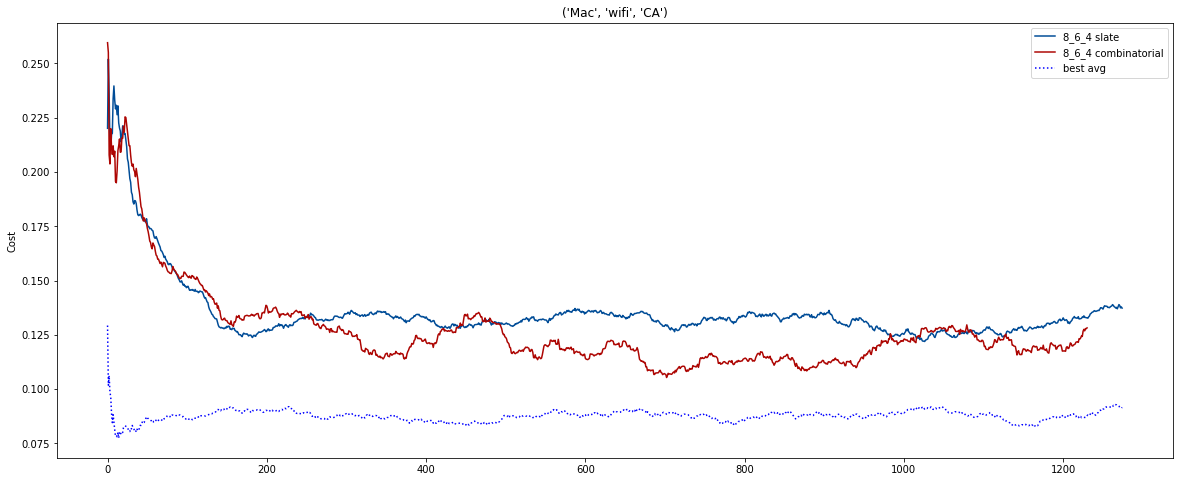

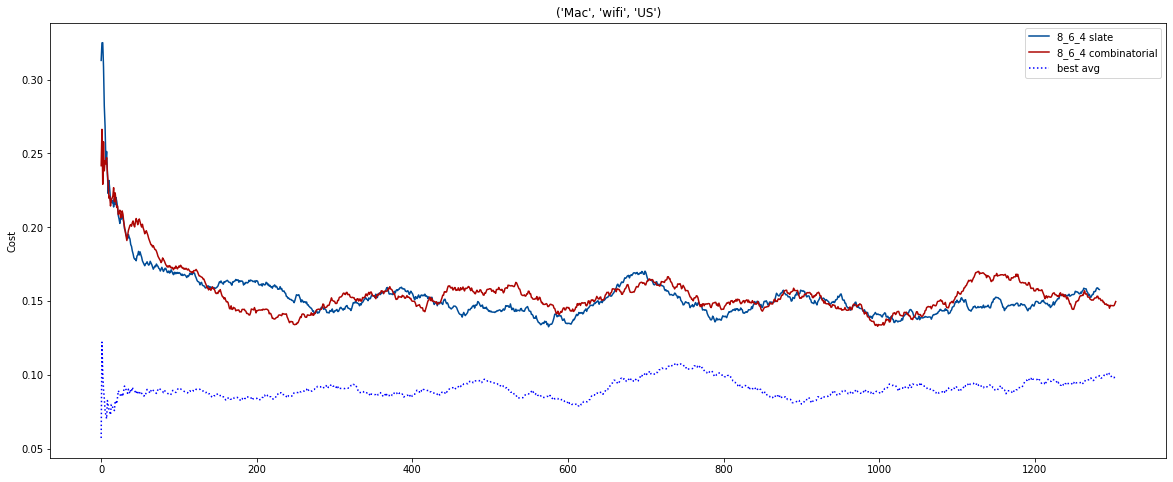

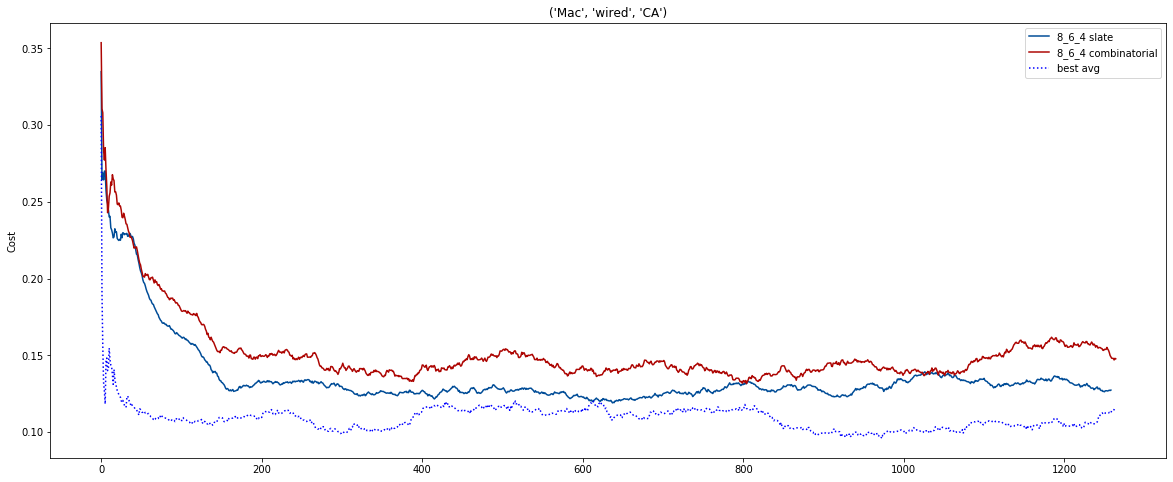

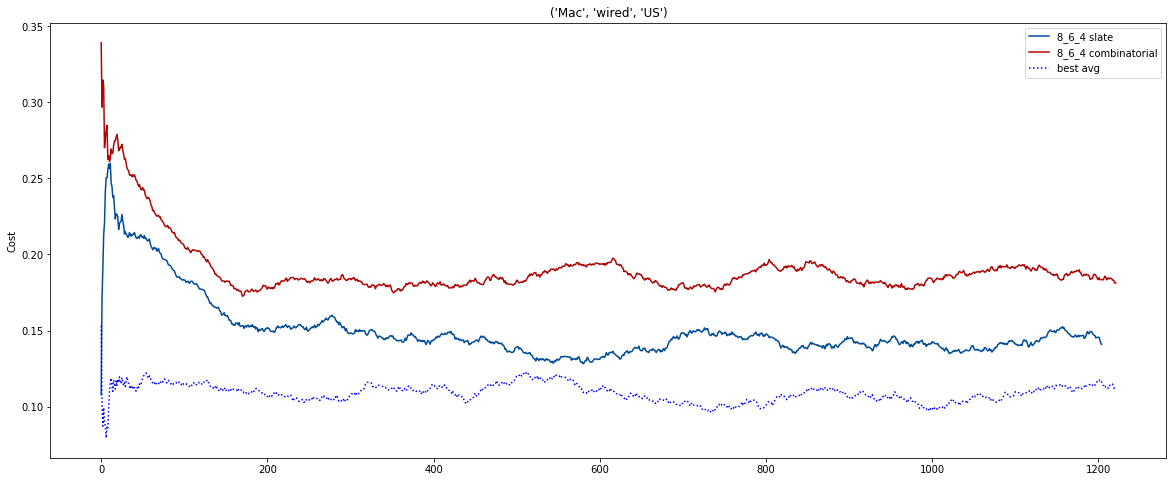

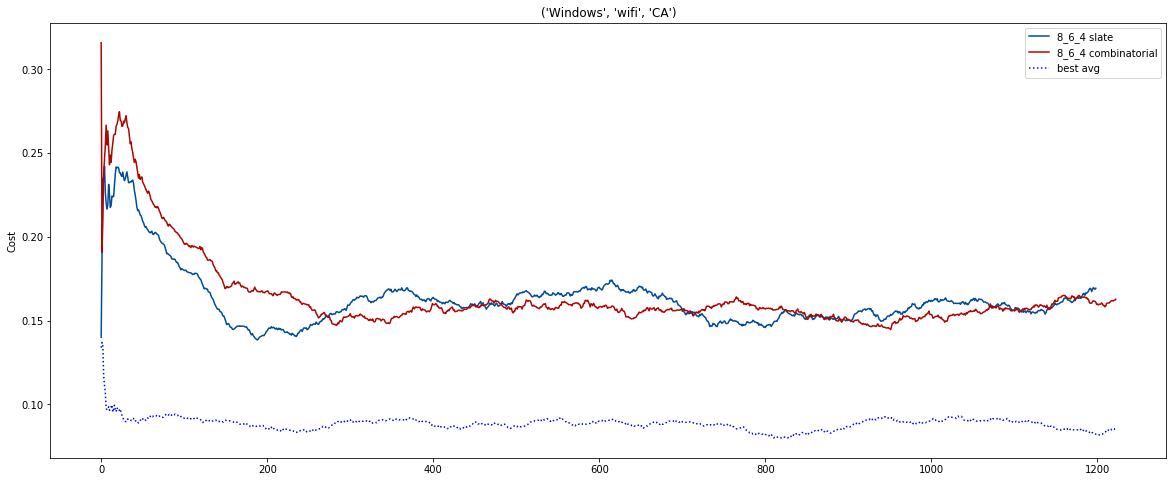

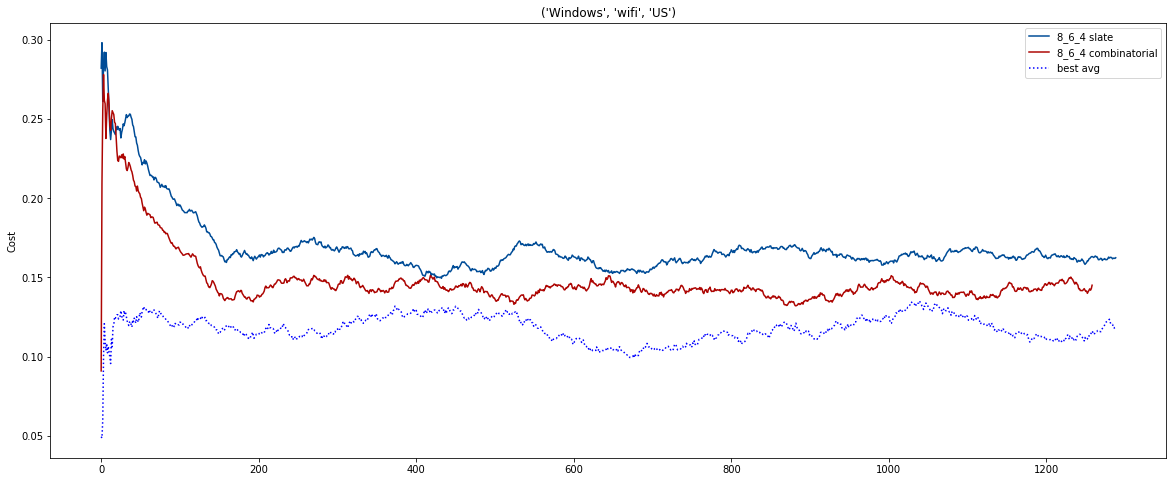

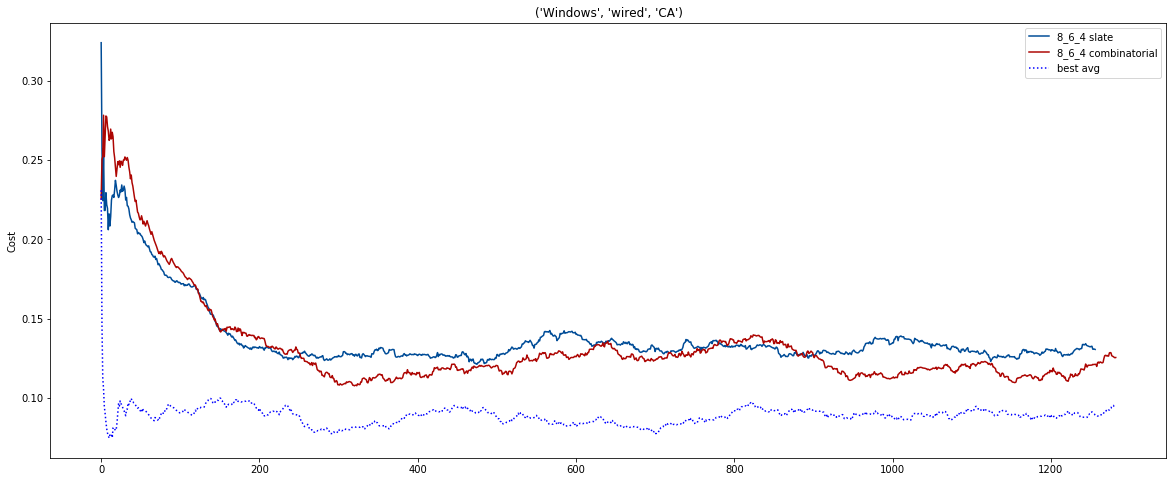

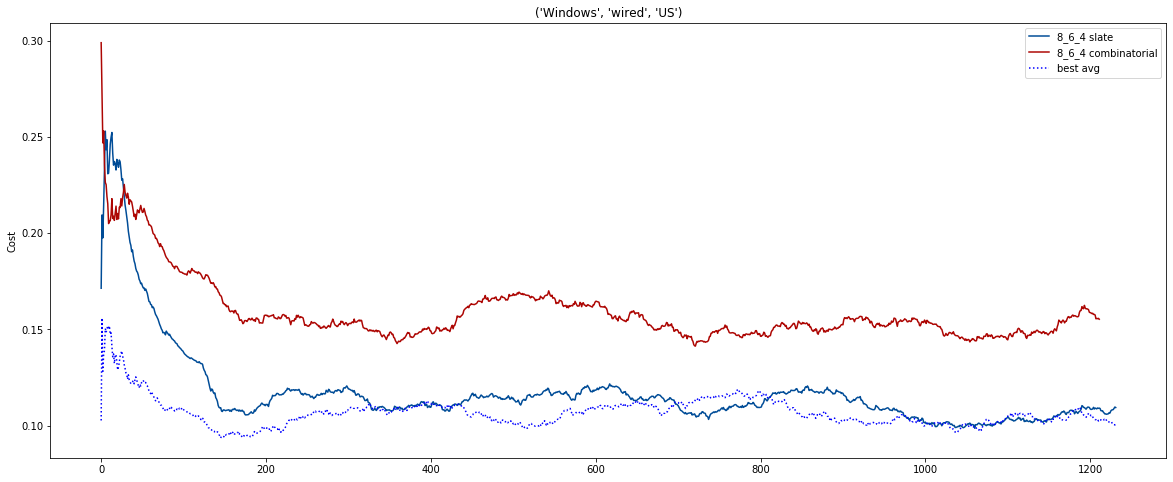

In [9]:
contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

slate_colors = ['#004c97','#000097','#009797']
cb_colors = ['#ad0603', '#ad5b03', '#ad0355']

for context in contexts:
    plt.figure(figsize=(20, 8))
    number_of_samples = max(len(test_configs[name]["outcomes"][context]), len(test_configs[name]["cb_outcomes"][context]))
    for i, name in enumerate(test_configs):
        plt.plot(pd.Series(test_configs[name]["outcomes"][context]).rolling(120, min_periods=0).mean(), color=slate_colors[i], label="{} slate".format(name))
        plt.plot(pd.Series(test_configs[name]["cb_outcomes"][context]).rolling(120, min_periods=0).mean(), color=cb_colors[i], label="{} combinatorial".format(name))
    
    plt.ylabel("Cost")
    # Plot optimal policy by sampling optimal policy number_of_samples times
    optimal_policy_results = [optimal_policy_sample(context, min_actions[context]) for i in range(number_of_samples)]
    plt.plot(pd.Series(optimal_policy_results).rolling(120, min_periods=0).mean(), color='b', linestyle=':', label="best avg")

    plt.title("{}".format(context))
    plt.legend(loc="upper right")
    plt.show()
 
